# Homework 4 (100 Points)

The goal of this homework is to get practice with classification.

## Exercise 1 (50 Points)

For this question we will re-use the "mnist_784" dataset from Homework 3.

a) Begin by creating a training and testing datasest from our dataset, with a 80-20 ratio, and random_state=1. You can use the `train_test_split` function from sklearn. By holding out a portion of the dataset we can evaluate how our model generalizes to unseen data (i.e. data it did not learn from). **- 5 Points**

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

b) Train a KNN model (on the training set) with any value of K you want and print out the confusion matrix when predicting the testing set. How well did your model perform? Which classes were most confused? - **5 Points**

<AxesSubplot:>

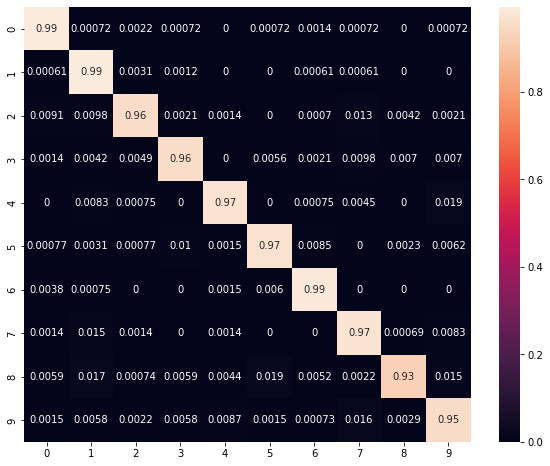

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
Y_test_predictions = neigh.predict(X_test)

# Plot a confusion matrix
cm = confusion_matrix(y_test, Y_test_predictions, normalize='true')
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True)

The model is good at almost class. But the class 8 (8th row) is relative the worse classification, it misclassified class 8 to class 5 (0.019), and class 9 (0.015). According to homework 3 (1i), the anomalous data is almost from number 8.

c) For K ranging from 1 to 20:
1. train a KNN on the training data - **3 points**
2. record the training and testing accuracy - **3 points**

Plot a graph of the training and testing set accuracy as a function of the number of neighbors K (on the same plot). Which value of K is optimal? Briefly explain.  **- 5 points**

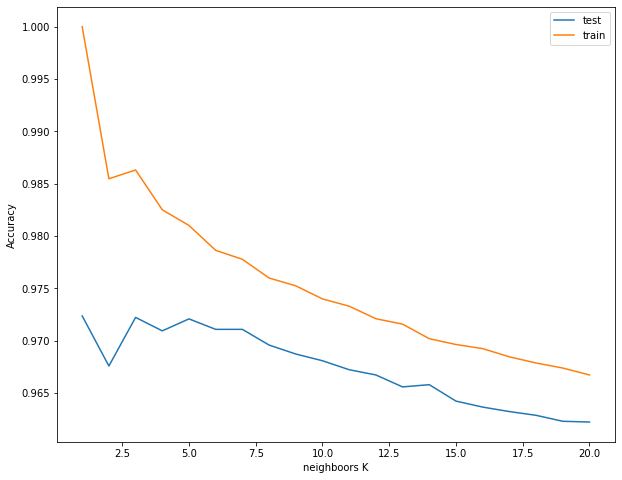

In [7]:
def plot_accuracy(test_scores, train_scores):
    plt.figure(figsize = (10,8))
    x = [i for i in range(1, len(test_scores) + 1)]
    plt.plot(x, test_scores, label='test')
    plt.plot(x, train_scores, label='train')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

test_scores = []
train_scores = []
for i in range(1, 21):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    test_scores.append(neigh.score(X_test, y_test))
    train_scores.append(neigh.score(X_train, y_train))
    
plot_accuracy(test_scores, train_scores)

K=5 is optimal. When K=1,3,5, the score of test is highest. However, the train is overfitting when K=1,3. Therefore, K=5 is optimal

d) Using the optimal model found in c), plot the confusion matrix and discuss. - **5 points**

<AxesSubplot:>

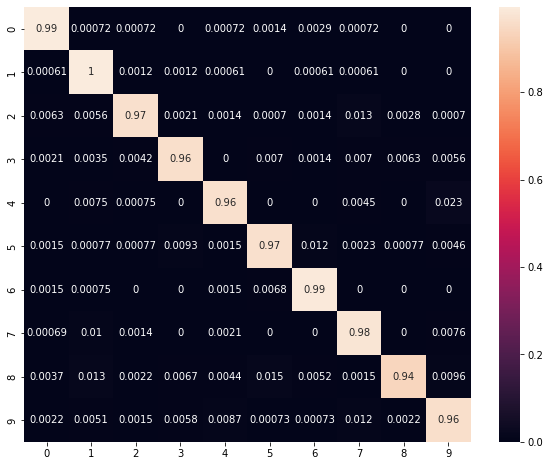

In [8]:
neigh_best = KNeighborsClassifier(n_neighbors=5)
neigh_best.fit(X_train, y_train)
Y_test_predictions = neigh_best.predict(X_test)

# Plot a confusion matrix
cm = confusion_matrix(y_test, Y_test_predictions, normalize='true')
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True)

The model looks similar as 1b, has a bad classification on class 8. it misclassified class 8 to class 1 (0.013), and class 5 (0.015). According to homework 3 (1i), the anomalous data is almost from number 8.

e) Using the entire dataset (training + testing set): Use k-fold cross validation (with k=10) to evaluate the perfomance of your KNN model. By varying K from 1 to 20 as in c), determine the optimal number of neighbors for your KNN model based on the mean cv accuracy. Plot a graph of the training and testing set accuracy (use the mean cv accuracy) as a function of the number of neighbors K (on the same plot). Which value of K is optimal? Discuss similarities or differences with results in c). **- 10 points**

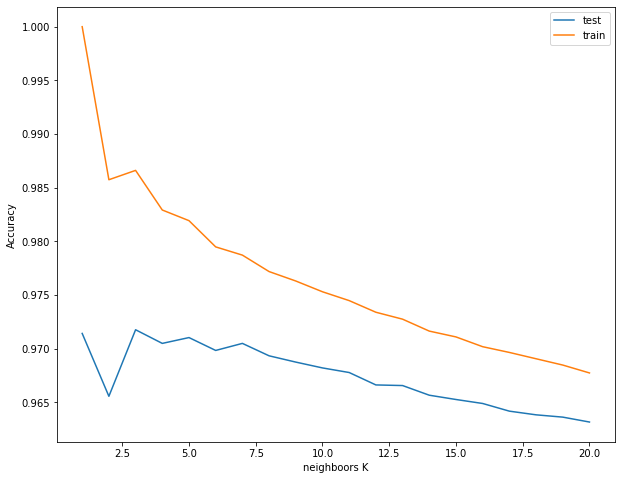

In [27]:
from sklearn.model_selection import cross_validate

test_scores = []
train_scores = []

for i in range(1, 21):
    neigh = KNeighborsClassifier(n_neighbors=i)
    cv_results = cross_validate(neigh, X, y, cv=10, return_train_score=True)
    test_scores.append(cv_results['test_score'].mean())
    train_scores.append(cv_results['train_score'].mean())

plot_accuracy(test_scores, train_scores)

f) Using the best model from d), pick an image at random and plot it next to its k nearest neighbors. **- 7 points**

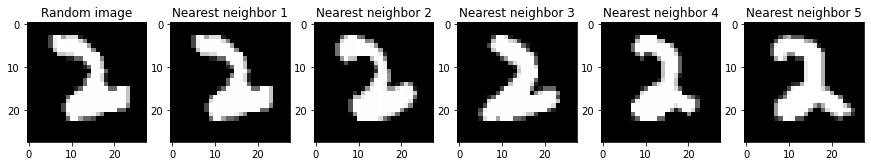

In [23]:
import random
import matplotlib.cm as cm

k = 5
ex = X[random.randint(0, len(X))]
plt.figure(figsize=(15,3))
_, neighbors = neigh_best.kneighbors([ex])
plt.subplot(1, k + 1, 1)
plt.imshow(ex.reshape(28, 28), cmap = cm.Greys_r)
plt.title('Random image')

i = 2
for n in neighbors[0]:
    plt.subplot(1, k + 1, i)
    plt.imshow(X_train[n].reshape(28, 28), cmap = cm.Greys_r)
    plt.title('Nearest neighbor ' + str(i - 1))
    i += 1
plt.show()

g) Using a dimensionality reduction technique discussed in class, reduce the dimensionality of the dataset before applying a KNN model. Repeat e) and discuss similarities and differences to the previous model. Briefly discuss your choice of dimension. **- 7 points**

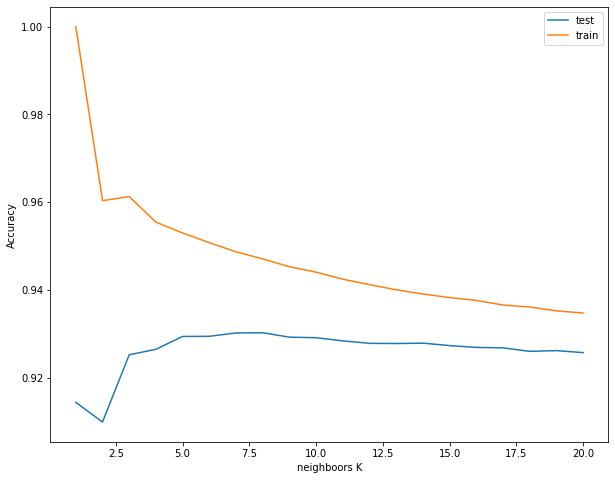

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD

test_scores = []
train_scores = []

for i in range(1, 21):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    model = make_pipeline(TruncatedSVD(10), knn_model)
    cv_results = cross_validate(model, X, y, cv=10, return_train_score=True)
    test_scores.append(cv_results['test_score'].mean())
    train_scores.append(cv_results['train_score'].mean())

plot_accuracy(test_scores, train_scores)

In homework 3 (1d), we discussed about the rank of SVD, and it shows the best dimension is 10.

## Exercise 2 (50 points)

This exercise will re-use the [Titanic dataset](https://www.kaggle.com/c/titanic/data) (https://www.kaggle.com/c/titanic/data) from homework 1. Download all files this time.

a) Informed by homework 1, handle the missing values in the datasets. Briefly explain. **-5 points**

In [35]:
import pandas as pd

df_train = pd.read_csv("train.csv")

# check null column
for i in df_train.columns:
    na = df_train[i].isna().sum()
    if na:
        print(i, na)

def handle_na(df):
    # fill the missing age
    female_age_mean = df[df.Sex == 'female'].Age.mean()
    male_age_mean = df[df.Sex == 'male'].Age.mean()

    df.loc[(df.Sex == 'female') & (df.Age.isna()), 'Age'] = female_age_mean
    df.loc[(df.Sex == 'male') & (df.Age.isna()), 'Age'] = male_age_mean

    # drop na embark
    df = df.dropna(subset=['Embarked'])
    return df

df_train = handle_na(df_train)

print()
# check null column
for i in df_train.columns:
    na = df_train[i].isna().sum()
    if na:
        print(i, na)

Age 177
Cabin 687
Embarked 2

Cabin 687


I filled the mission age by using the mean of male and female. And delete the empty Embarked, as the number is small. And we don't deal with cabin, because we won't use it.

b) Informed by homework 1, add 2 new features / columns to the datasets that you think might be related to the survival of individuals. Explain. **-5 points**

In [36]:
def extract_titles_and_alone(df):
    result = []
    alone = []
    for index, row in df.iterrows():
        name = row.Name.replace('"', '').strip()
        fullname = name.split(",")
        lastName = fullname[0]
        fullname = fullname[1].strip().split('.', 1)
        title = fullname[0]
        fullname = fullname[1].strip().split(' ')

        if row.Parch > 0 or row.SibSp > 0:
            alone = 0
        else:
            alone = 1
        result.append([title, alone])
    return result

df_train[['Title', 'Alone']] = extract_titles_and_alone(df_train)

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1


Title: the title of the name. Alone: if the person has parch or sibsp, then alone=1, or alone=0

c) Train a Decision Tree Classifier using all features you think may be related to survival (justify any that you remove). Set the `max_depth` parameter to an appropriate quantity to reduce the runtime and avoid overfitting. Explain. **- 10 points**

Removed columns: passengerid, survived (it's output), Name (only use title in the name), SibSp, Parch (use alone), Ticket, Cabin

In [37]:
from sklearn.tree import DecisionTreeClassifier

title_list = df_train.Title.unique().tolist()
title_list.append('Null')
for i, t in enumerate(title_list):
    print(i, t)

def convert_to_numeric(df):
    X = df.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1)
    if 'Survived' in df:
        X = X.drop(['Survived'], axis=1)
    for index, row in X.iterrows():
        # replace sex male with 0, female with 1
        if row.Sex == 'male':
            X.loc[index, 'Sex'] = 0
        elif row.Sex == 'female':
            X.loc[index, 'Sex'] = 1

        # replace embarked C with 0, Q with 1, S with 2
        if row.Embarked == 'C':
            X.loc[index, 'Embarked'] = 0
        elif row.Embarked == 'Q':
            X.loc[index, 'Embarked'] = 1
        elif row.Embarked == 'S':
            X.loc[index, 'Embarked'] = 2

        # replace Title with the index in title_list
        if row.Title in title_list:
            X.loc[index, 'Title'] = title_list.index(row.Title)
        else:
            X.loc[index, 'Title'] = title_list.index('Null')
    return X

X = convert_to_numeric(df_train)
y = df_train.Survived

train_scores = []
test_scores = []
for i in range(1, 21):
    dt_model = DecisionTreeClassifier(random_state=0, max_depth=i)
    cv_results = cross_validate(dt_model, X, y, cv=10, return_train_score=True)
    test_scores.append(cv_results['test_score'].mean())
    train_scores.append(cv_results['train_score'].mean())

plot_accuracy(test_scores, train_scores)

0 Mr
1 Mrs
2 Miss
3 Master
4 Don
5 Rev
6 Dr
7 Mme
8 Ms
9 Major
10 Lady
11 Sir
12 Mlle
13 Col
14 Capt
15 the Countess
16 Jonkheer
17 Null


NameError: name 'plot_accuracy' is not defined

As the image showed, the optimal depth is 4.

d) Plot the decision tree. Briefly explains how it works. **- 5 points**

,Pclass,Sex,Age,Fare,Embarked,Title,Alone
121,3,0,30.726645,8.0500,2,0,1
687,3,0,19.000000,10.1708,2,0,1
790,3,0,30.726645,7.7500,1,0,1
837,3,0,30.726645,8.0500,2,0,1
659,1,0,58.000000,113.2750,0,0,0


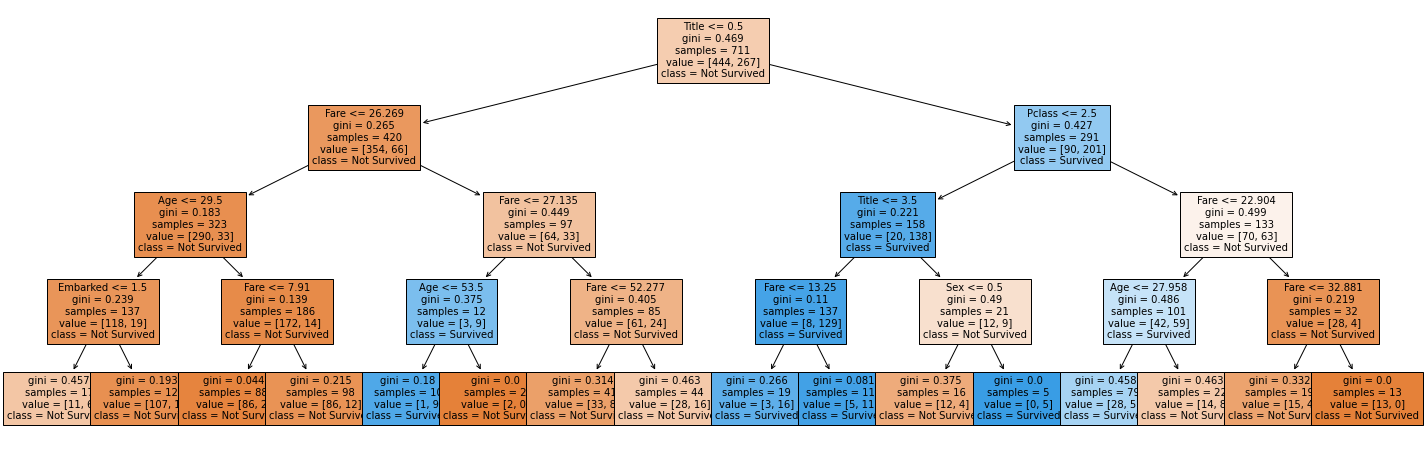

In [38]:
from sklearn.tree import plot_tree

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
dt = DecisionTreeClassifier(random_state=0, max_depth=4)
dt.fit(X_train, y_train)
plt.figure(figsize=(25,8))
plot_tree(dt, fontsize=10, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'])
X_train.head()

The first 2 level of the tree:  
First, check the title, if title<=0.5 (e.g. Title=Mr.), then check the Fare, or check the Pclass.  
In this tree, it's ignored the Alone. 

e) Evaluate the classifier on the test set by plotting the confusion matrix. Comment on the pitfalls of the model (to help: For the examples that were misclassified, choose two at random and walk through the decision tree with their attributes and try to understand why the misclassification occured). **- 10 points**

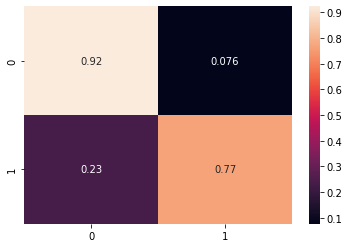

Pclass             1
Sex                1
Age             58.0
Fare        146.5208
Embarked           0
Title              2
Alone              1
Name: 195, dtype: object
1
Pclass             1
Sex                1
Age             50.0
Fare        247.5208
Embarked           0
Title              1
Alone              0
Name: 299, dtype: object
1


In [39]:
df_pred = dt.predict(X_test)

# Plot a confusion matrix
cm = confusion_matrix(y_test, df_pred, normalize='true')
plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True)
plt.show()

id = random.randint(0, len(X_test))
print(X_test.iloc[id])
print(y_test.iloc[id])
id = random.randint(0, len(X_test))
print(X_test.iloc[id])
print(y_test.iloc[id])
path2 = dt.decision_path([X_test.iloc[id].values])

f) Tune the parameters of the decision tree to improve its performance. Explain what you tried and what you observed. **- 5 points**

g) Reduce the dimension of the dataset to 5 before creating a Decision Tree Classifier. Evaluate this classifier by plotting the confusion matrix. Comment on performance differences you observe. How interpretable is this model? Explain. **- 10 points**

In [ ]:
dt_model = DecisionTreeClassifier(random_state=0, max_depth=10)
model = make_pipeline(TruncatedSVD(5), dt_model)

df_pred = dt.predict(df)

# Plot a confusion matrix
cm = confusion_matrix(y_test, df_pred, normalize='true')
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True)

# Bonus (40 Points)

## Random Forests
 Random Forest algorithm is an extension to the decision trees. We make use of multiple decision trees to make a decsion(classification/regression) in Random Forests.

Ensemble modelling is a method of constructing a strong model using several weak models. Random Forests algorithm is one such ensemble model

Multiple small decision trees trained on random parts of the training data collectively make a decision on an input point. The number of trees in this Random Forest algorithm is a hyper-parameter that you need to finetune to get the best output from this model. 

Every time you construct a tree, you pick random samples of size 'k'(k samples) from the total dataset and construct the tree. Make sure your tree depth is not very high, or the individual tree could overfit to the data. We want the collective model to generalize well to multiple datasets. 

During classification, we consider the decision of the majority of trees to be the final decision. 

- In this task, you are supposed to construct a random forests algorithm on the 'Titanic' dataset making use of your decision trees from **1c** and get the classification outputs. 
 
 

**Note**: Your are not supposed to use random forests model from sklearn or any other library, but however, you can use those libraries to construct multiple decision trees 

You can use any other library for your convenience, unless you are not trying to load a Random forest model from those libraries. 

### Construct your model (10 points)

In [69]:
from sklearn import tree
from collections import Counter
from sklearn.metrics import accuracy_score
import numpy as np

# Here is suggested template for you to use
# But feel free to do something different
class Random_Forest():

    def __init__(self, num_trees, max_depth, criterion):
        self.max_depth = max_depth
        self.criterion = criterion
        self.decision_trees = [tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth) for _ in range(num_trees)]

    def _fit_tree(self, X, y, idx):
        self.decision_trees[idx].fit(X, y)

    def _sample(self, X, y):
        rng = np.random.default_rng()
        idx = np.random.choice(np.arange(len(X)), 500, replace=False)
        return X.iloc[idx], y.iloc[idx]

    def fit(self, X, y):
        for idx in range(len(self.decision_trees)):
            X_sample, y_sample = self._sample(X, y)
            self._fit_tree(X_sample, y_sample, idx)
    
    def _majority(self, predictions):
        # your code here
        prediction = []
        for i in range(len(predictions[0])):
            count = Counter(predictions[:, i]).most_common(1)
            prediction.append(count[0][0])
        return prediction
    
    def predict(self, X_test, y_test):
        # your code here
        predictions = np.array([dt.predict(X_test) for dt in self.decision_trees])
        return self._majority(predictions)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X, y))


### Hyperparameter tuning, and model evaluation for random forests. (25 points)

In order to avoid the cases of overfitting, we apply something called 'pruning' to the decision trees in this algorithm. Pruning is a method to cut the trees beyond a certain depth. This introduces ambiguity and randomness to the output, while increasing the generalization capability. 

 - Experiment with tree sizes(tree depth) of depth = 5,10,15
 - Experiment with different number of trees [10,50,100,500,1000] and report accuracies
 - Experiment with different information criteria ['gini index', 'entropy'] 


Report the accuracy of your best model, and compare it with your accuracy of the decision tree from **1c**. Write your observations on Random Forests algorithm

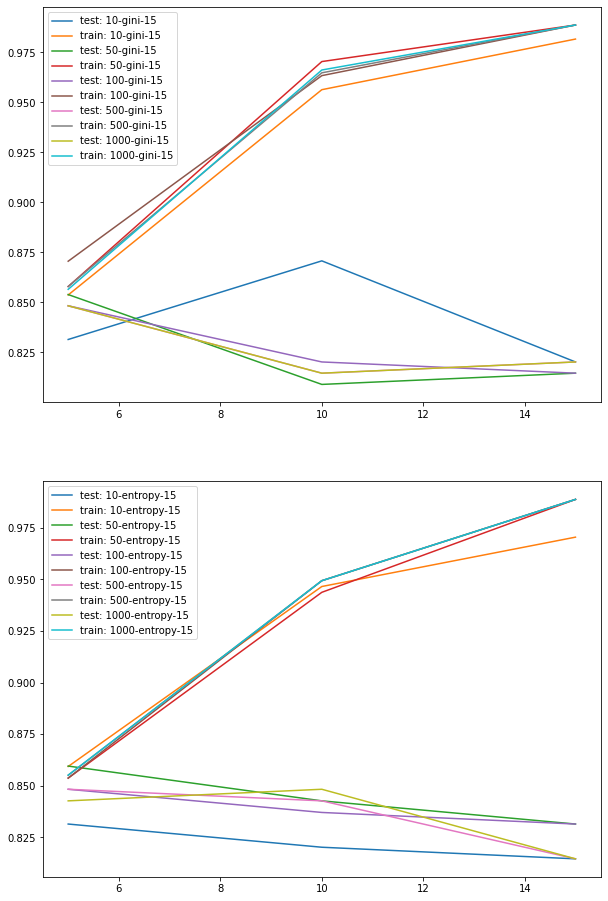

In [88]:
# write your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

plt.figure(figsize = (10,16))
x = [5, 10, 15]
plt.ylabel('Accuracy')
plt.xlabel('Depth')

pos = 1
for info in ['gini', 'entropy']:
    plt.subplot(2,1,pos)
    pos+=1
    for number in [10, 50, 100, 500, 1000]:
        test_scores = []
        train_scores = []
        for depth in [5,10,15]:
            model = Random_Forest(number, depth, info)
            model.fit(X_train, y_train)
            test_scores.append(model.score(X_test, y_test))
            train_scores.append(model.score(X_train, y_train))
        plt.plot(x, test_scores, label='test: %d-%s-%d' % (number, info, depth))
        plt.plot(x, train_scores, label='train: %d-%s-%d' % (number, info, depth))
        plt.legend()

plt.show()               

### Calculations (5 points)

$$ \text{Information gain} = \text{(Entropy of Parent Node)} - \sum_{c}{\text{(entropy of child node)} }$$

$$Entropy = \sum_{i=1}^{C} -p_{i}log(p_{i})$$
$$p_{i} = \frac{C_{i}}{ \sum_{j=1}^{C} C_{j}}$$
$$C_{i} = \text{Count of elements belonging to class 'i'}$$
$$C = \text{Total Number of Elements}$$

We have total data of 50,000 samples

- We randomly sampled about 5000 samples and trained a decision tree. 
- We are trying to classify the samples at a node for one of the tree 'T'
- Parent Node has 34 samples, out of which 15 are positive, and 19 are negative 
- We divided the node based on a particular column, and now we have two child nodes
- Child 1 has 13 samples, of which 9 are positive and 4 are negative
- Child 2 has 21 samples, of which 6 are positive and 15 are negative,

Calculate the information gain for splitting the parent note based on that column

**Note:** You can attach a handwritten image for this part or write your answer in the markdown cell below. 
